In [111]:
import math
import sys

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

sys.path.append('..\..')
from fairness import fairestimator

In [163]:
x_cols = ['sex', 'age', 'race', 'decile_score']
y_col = ['is_recid']
# data taken from https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv
df = pd.read_csv(r'data\compas-scores-two-years.csv', usecols=x_cols + y_col)

X_train, X_test, y_train, y_test = train_test_split(df[x_cols], df[y_col].squeeze(), random_state=42)

In [146]:
clf = RandomForestClassifier(min_samples_leaf=100, max_depth=4)

In [147]:
pipe_unaware = Pipeline([('make_unaware', ColumnTransformer([('make_unaware', "passthrough", ['decile_score'])])),
                         ('clf', clf)])
pipe_unaware.fit(X_train, y_train)
y_pred_unaware = pd.Series(pipe_unaware.predict(X_train), index=X_train.index, name='PredUnaware')

In [148]:
pipe_aware = Pipeline([('preprocessing', ColumnTransformer([('onehoteencoder', OneHotEncoder(drop='first', sparse_output=False), ['sex', 'race'])], remainder='passthrough')),
                         ('clf', clf)])
pipe_aware.fit(X_train, y_train)
y_pred_aware = pd.Series(pipe_aware.predict(X_train), index=X_train.index, name='PredAware')


In [149]:
pipe_fair = Pipeline([('preprocessing', ColumnTransformer([('onehoteencoder', OneHotEncoder(drop='first', sparse_output=False), ['sex', 'race'])], remainder='passthrough')),
                         ('clf', fairestimator.IgnoringBiasClassifier(clf, range(6), correction_strategy='Logitadditive'))])
pipe_fair.set_output(transform="pandas")
pipe_fair.fit(X_train, y_train)
y_pred_fair = pd.Series(pipe_fair.predict(X_train), index=X_train.index, name='PredFair')


In [150]:
outcomes = pd.concat([X_train, y_pred_fair, y_pred_aware, y_pred_unaware, y_train], axis='columns')
outcomes

,sex,age,race,decile_score,PredFair,PredAware,PredUnaware,is_recid
4697,Male,35,Caucasian,1,0,0,0,0
5884,Male,69,Caucasian,1,0,0,0,1
5035,Male,43,African-American,1,0,0,0,0
6217,Male,21,Caucasian,4,1,1,0,1
3428,Male,43,Caucasian,1,0,0,0,0
...,...,...,...,...,...,...,...,...
3772,Male,28,African-American,2,0,0,0,0
5191,Male,30,African-American,8,1,1,1,0
5226,Female,33,Caucasian,1,0,0,0,0
5390,Male,27,African-American,3,0,0,0,0


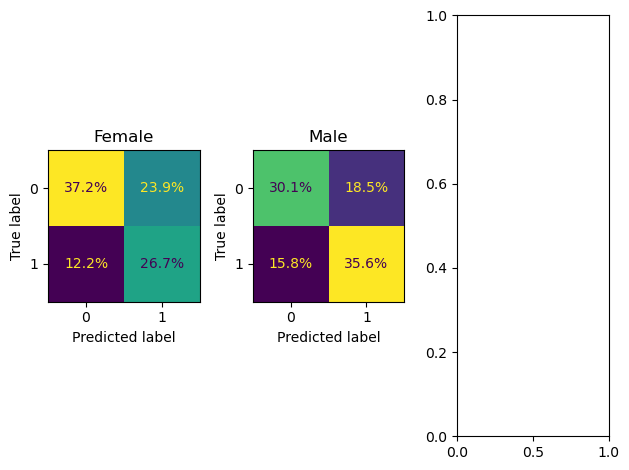

In [151]:
def plot_conf_matrix_per_attribute(df, attribute, col_prediction, col_true='is_recid'):
    n_groups = df[attribute].nunique()
    fig, axes = plt.subplots(math.ceil(n_groups / 3), 3)
    for (groupname, df_subgroup), ax in zip(df.groupby(attribute), axes.flat):
        ConfusionMatrixDisplay.from_predictions(df_subgroup[col_true], df_subgroup[col_prediction], normalize='all', values_format='.1%', ax=ax, colorbar=False)
        ax.set_title(groupname)
    plt.tight_layout()

plot_conf_matrix_per_attribute(outcomes, 'sex', 'PredFair')

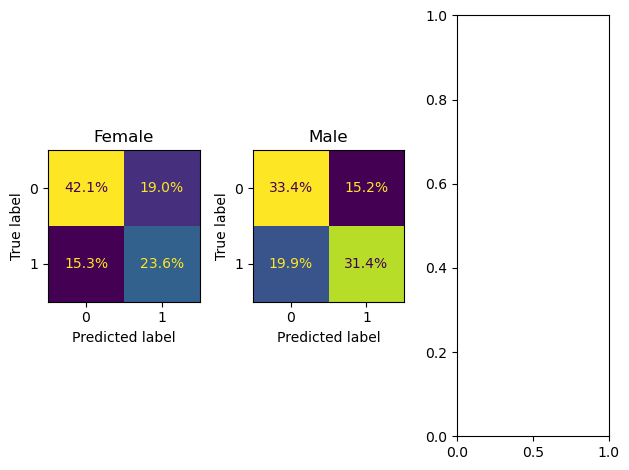

In [152]:
plot_conf_matrix_per_attribute(outcomes, 'sex', 'PredUnaware')